# Combine spectrogram chunks containing click events with synthetic noise spectrogram chunks

This notebook is the implementation of the corresponding part in section ***5.4.2 Data augmentation*** of the chapter ***5 Experiments*** for creating the augmented datasets (referred to as **Dataset 5** in the documentation) by combining spectrogram chunks created from recorded click audio with synthetic noise chunks. The augmented datasets are created for all of the three connector types with spectrogram chunk size of 32 × 128 for the **Ethernet** and **HVA 630** connectors and with a chunk size of 64 × 128 for the **HVA 280** connetor. More details on the implementation steps can be found in the thesis.

### 1. Import libraries and moduls

In [1]:
# all libraries used in this notebook
import sys
import os.path
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
import importlib

In [2]:
# import necessary functions from the folder "06_Utilities" for audio file processing and mel-spectrogram plotting

cwd = str(Path.cwd())                                               ## current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent)                                  ## parent dir of the current working directory, should be the project directory
utilities_dir_full_path = os.path.join(parent_dir, "06_Utilities")  ## full path to the "05_Utilities" folder

sys.path.append(utilities_dir_full_path)                            ## add the path of the "05_Utilities" folder to the sys.path list

import audioProcessing                                              ## import the modul for audio file processing and mel-spectrogram generation
import spectrogramPlotting                                          ## import the modul for mel-spectrogram visualization
import sharedValues                                                 ## import the modul for shared variables between the classes

importlib.reload(audioProcessing)
importlib.reload(spectrogramPlotting)
importlib.reload(sharedValues)

# make instances of the classes in the modules
processAudio = audioProcessing.processAudio()
spectrogramPlotter = spectrogramPlotting.spectrogramPlotter()
sharedValuesConfig =sharedValues.sharedValuesConfig()

### 2. Load recorded noise audio files

In [3]:
# sorting function for files and directories

def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

In [4]:
# list all audio file datasets in folder "01_Dataset/01_audioDatasets"

cwd = str(Path.cwd())
parent_dir = os.path.dirname(cwd)
audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
audio_datasets_main_dir = os.path.join(parent_dir, audio_datasets_main_dir)

audio_datasets = []
if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets)
else:
    print("Audio dataset directory does not exist")

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [6]:
# load positive (click) samples from the selected dataset

dataset_num = 0 # index of the selected dataset: 0 - ethernet, 2 - hva 280, 4 - hva 630

loaded_spec_chunks = None
loaded_spec_chunk_labels = None

long_window = False

dataset_dir = os.path.join(audio_datasets_main_dir, audio_datasets[dataset_num])
file_list = [f for f in os.listdir(dataset_dir) if f.endswith('.npz')]              ## find .npz files
if len(file_list) == 0:
    print(f"No npz file in the directory")
else:
    print(file_list)

    if dataset_num == 0:
        file = "ethernet_dataset.npz"
    elif dataset_num == 2:
        file = "hva280_dataset.npz"
        long_window = True
    elif dataset_num == 4:
        file = "hva630_dataset.npz"

    print(f"file: {file}")
    
    file_fullpath = os.path.join(dataset_dir, file)

    data = np.load(file_fullpath)

    if loaded_spec_chunks is None:
        loaded_spec_chunks = data['spec_chunks']        ## add spectrogram chunks to a numpy array if the array is empty
        loaded_spec_chunk_labels = data['labels']       ## add labels to a numpy array if the array is empty
    else:
        loaded_spec_chunks = np.concatenate((loaded_spec_chunks, data['spec_chunks']), axis=0)          ## concatenate spectrogram chunks to the existing numpy array
        loaded_spec_chunk_labels = np.concatenate((loaded_spec_chunk_labels, data['labels']), axis=0)   ## concatenate labels to the existing numpy array

print(len(loaded_spec_chunks))
print(f"positive samples: {np.count_nonzero(loaded_spec_chunk_labels == 1)}")

## create new numpy array with only positive samples (click chunks)

positive_sample_mask = loaded_spec_chunk_labels == 1
spec_chunks_click = loaded_spec_chunks[positive_sample_mask]
spec_chunk_labels_click = loaded_spec_chunk_labels[positive_sample_mask]

## get information about the dataset
print(len(spec_chunks_click))
print(f"positive samples: {np.count_nonzero(spec_chunk_labels_click == 1)}")
print(np.max(spec_chunks_click))
print(np.min(spec_chunks_click))

['ethernet_dataset.npz']
file: ethernet_dataset.npz
2640
positive samples: 240
240
positive samples: 240
-6.131253
-120.0


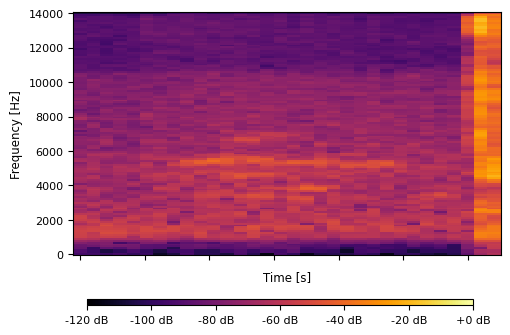

In [7]:
# plot mel-scaled spectrogram containing click from the dataset

chunk_id_to_plot = 0

top_dB_abs = 120
f_min = 20
f_max = 14000
n_mels = 128

spectrogramPlotter.plot_single_mel_spectrogram(spec_chunks_click[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)

In [8]:
# load dataset with generated spectrogram chunks

cwd = str(Path.cwd())
parent_dir = os.path.dirname(cwd)
generated_noise_dir = "02_Data_Augmentation/01_augmentedDatasets/04_Noise_Samples" ## directory with generated noise samples
generated_noise_dir_full_path = os.path.join(parent_dir, generated_noise_dir)

file_list_noise = [f for f in os.listdir(generated_noise_dir_full_path) if f.endswith('.npz')]

spec_chunks_noise = None
spec_chunk_labels_noise = None

print(file_list_noise)
if len(file_list_noise) == 0:
    print(f"No npz file in the directory")
else:
    if long_window:
        file = 'noise_dataset_generated_long_window.npz'    ## use the long window noise dataset for hva280
    else:
        file = 'noise_dataset_generated.npz'                ## use the short window noise dataset for ethernet and hva630

    print(f"file: {file}")
        
    file_fullpath = os.path.join(generated_noise_dir_full_path, file)
    print(file_fullpath)

    data = np.load(file_fullpath)

    if spec_chunks_noise is None:
        spec_chunks_noise = data['spec_chunks']             ## add spectrogram chunks to a numpy array if the array is empty
        spec_chunk_labels_noise = data['labels']            ## add labels to a numpy array if the array is empty
    else:
        spec_chunks_noise = np.concatenate((spec_chunks_noise, data['spec_chunks']), axis=0)            ## concatenate spectrogram chunks to the existing numpy array
        spec_chunk_labels_noise = np.concatenate((spec_chunk_labels_noise, data['labels']), axis=0)     ## concatenate labels to the existing numpy array


## reduce noise level by linarly mapping the values to the desired range -> maximal dB value is defined with the noise_reduction_dB_threshold
def reduce_noise_dB(D_mel_dB, noise_reduction_dB_threshold):
    
    D_mel_dB = D_mel_dB * (noise_reduction_dB_threshold/((top_dB_abs/(top_dB_abs-noise_reduction_dB_threshold))*noise_reduction_dB_threshold)) - noise_reduction_dB_threshold

    return D_mel_dB

noise_reduction_dB_threshold_abs = 20   ## define the maximal dB value for the noise reduction
                                        ## this value was selected to be samaller than the max abs dB value at around 15 dB for the hva630, the connector with the lowes max dB value
spec_chunks_noise_reduced = np.copy(spec_chunks_noise)
for i in range(len(spec_chunks_noise_reduced)):
    spec_chunks_noise_reduced[i] = reduce_noise_dB(spec_chunks_noise_reduced[i], noise_reduction_dB_threshold_abs)

print(len(spec_chunks_noise))
print(f"positive samples: {np.count_nonzero(spec_chunk_labels_noise == 1)}")

print(np.min(spec_chunks_noise), np.max(spec_chunks_noise))

print(len(spec_chunks_noise_reduced))
print(np.min(spec_chunks_noise_reduced), np.max(spec_chunks_noise_reduced))

['noise_dataset_generated_long_window.npz', 'noise_dataset_generated.npz']
file: noise_dataset_generated.npz
/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/02_Data_Augmentation/01_augmentedDatasets/04_Noise_Samples/noise_dataset_generated.npz
3000
positive samples: 0
-114.74159 -7.991646
3000
-115.61799 -26.659704


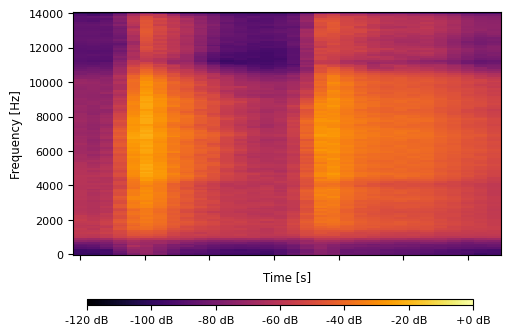

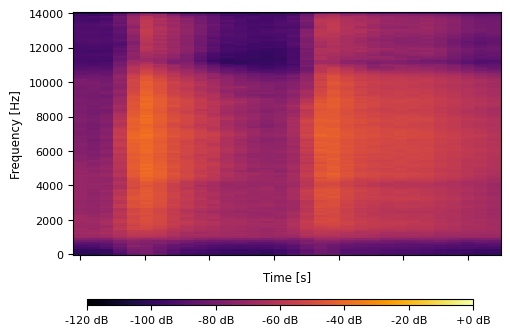

In [9]:
# plot a mel-scaled spectrogram from the noise dataset with the original dB levels and vith the reduced dB level

noise_chunk_id_to_plot = 0

spectrogramPlotter.plot_single_mel_spectrogram(spec_chunks_noise[noise_chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)

# plot reduced sample
spectrogramPlotter.plot_single_mel_spectrogram(spec_chunks_noise_reduced[noise_chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)

### 3. Combine spectrograms
The theory behind the individual steps is detailed in section ***4.2.3 Data Augmentation*** of the thesis. 

In [10]:
# convert back from dB to power

## pover_mel_to_dB conversion: D_mel_dB = 10.0 * np.log10(np.maximum(d_min, np.minimum(D_mel, d_ref))/d_ref)
## since adding two signals is only possible in power domain (Roberts 1984), spectogram chunks are converted back first to power domain

## create a copy of spec_chunks_click
spec_chunks_click_power = np.copy(spec_chunks_click)

## create a copy of spec_chunks_noise and spec_chunks_noise_reduced
spec_chunks_noise_power = np.copy(spec_chunks_noise)
spec_chunks_noise_reduced_power = np.copy(spec_chunks_noise_reduced)

## get the reference values for dB conversion from the sharedValuesConfig class
d_ref = sharedValuesConfig.D_REF    ## reference value for dB conversion
d_min = sharedValuesConfig.D_MIN    ## min value for dB conversion

## function for converting dB to power
def db_to_power_mel(D_mel_dB, d_ref):

        D_mel = np.power(10.0, D_mel_dB/10) * d_ref

        return D_mel

## convert all the chunks from dB to power for click, noise and noise reduced
for i in range(len(spec_chunks_click_power)):
    spec_chunks_click_power[i] = db_to_power_mel(spec_chunks_click_power[i], d_ref)

for i in range(len(spec_chunks_noise_power)):
    spec_chunks_noise_power[i] = db_to_power_mel(spec_chunks_noise_power[i], d_ref)

for i in range(len(spec_chunks_noise_reduced_power)):
    spec_chunks_noise_reduced_power[i] = db_to_power_mel(spec_chunks_noise_reduced_power[i], d_ref)

## get information about the dataset
print(len(spec_chunks_click_power))
print(np.max(spec_chunks_click_power))

print(len(spec_chunks_noise_power))
print(np.max(spec_chunks_noise_power))
print(spec_chunks_noise_power[0].shape)

print(len(spec_chunks_noise_reduced_power))
print(np.max(spec_chunks_noise_reduced_power))
print(spec_chunks_noise_reduced_power[0].shape)

240
243.71077
3000
158.79448
(128, 32)
3000
2.1578918
(128, 32)


In [11]:
# combine click chunks and noise chunks with reduced noise level

np.random.seed(42) ## for reproducibility

## upsample click chunks to noise the number of noise chunks
spec_chunks_click_power_upsampled = spec_chunks_click_power[np.random.choice(len(spec_chunks_click_power), 
                                                                             len(spec_chunks_noise_power), 
                                                                             replace=True)].copy()
print(len(spec_chunks_click_power_upsampled))

## create a copy of the upsampled click chunks, noise chunks and noise reduced chunks
spec_chunks_click_power_upsampled_copy = spec_chunks_click_power_upsampled.copy()
spec_chunks_noise_power_copy = spec_chunks_noise_power.copy()
spec_chunks_noise_reduced_power_copy = spec_chunks_noise_reduced_power.copy()

## shuffle the chunks
np.random.shuffle(spec_chunks_click_power_upsampled_copy)
np.random.shuffle(spec_chunks_noise_power_copy)
np.random.shuffle(spec_chunks_noise_reduced_power_copy)

spec_chunks_click_augmented_power = spec_chunks_click_power_upsampled_copy + spec_chunks_noise_reduced_power_copy

3000


In [15]:
# convert back the chunks from power to dB

## create a copy of the augmented chunks
spec_chunks_click_augmented_dB = np.copy(spec_chunks_click_augmented_power)

## function for converting power to dB
def power_mel_to_db(D_mel, d_min, d_ref):

        D_mel_dB = 10.0 * np.log10(np.maximum(d_min, np.minimum(D_mel, d_ref)/d_ref))

        return D_mel_dB

for i in range(len(spec_chunks_click_augmented_dB)):
    spec_chunks_click_augmented_dB[i] = power_mel_to_db(spec_chunks_click_augmented_dB[i], d_min, d_ref)

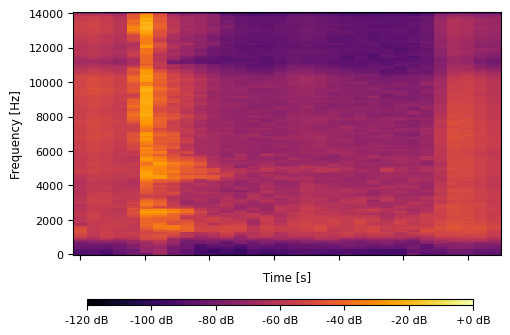

In [16]:
# plot an augmented sample from the dataset

augmented_chunk_id_to_plot = 0

spectrogramPlotter.plot_single_mel_spectrogram(spec_chunks_click_augmented_dB[augmented_chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)

In [17]:
# create label array with the length of the augmented samples

spec_chunks_click_augmented_dB_labels = np.ones(len(spec_chunks_click_augmented_dB))        ## create an array of ones with the length of the augmented samples
                                                                                            ## each chunk contains click --> label = 1

print(len(spec_chunks_click_augmented_dB_labels))
print(np.count_nonzero(spec_chunks_click_augmented_dB_labels == 1))

3000
3000


### 4. Save the augmented dataset

In [ ]:
# save the mixed click-noise spectrogram dataset and labels in .npz format

connector = None

if dataset_num == 0:
    connector = "ethernet"
    augmendet_directory = "01_Ethernet"
elif dataset_num == 2:
    connector = "hva280"
    augmendet_directory = "02_HVA280"
elif dataset_num == 4:
    connector = "hva630"
    augmendet_directory = "03_HVA630"

save_directory = os.path.join(cwd, "01_augmentedDatasets", augmendet_directory)
filename = f"{connector}_dataset_augmented_w_generated_noise.npz"
file_fullpath = os.path.join(save_directory, filename)

spec_chunk_dataset = np.array(spec_chunks_click_augmented_dB)           ## convert the list of augmented chunks to a numpy array
spec_chunk_labels = np.array(spec_chunks_click_augmented_dB_labels)     ## convert the list of labels to a numpy array

np.savez(file_fullpath, spec_chunks=spec_chunk_dataset, labels=spec_chunk_labels)